<a name='1'></a>
## 1 - Packages

Run the following code cell to import the necessary packages and dependencies you will need to perform Neural Style Transfer.

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

In [ ]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

In [ ]:
## Content image read

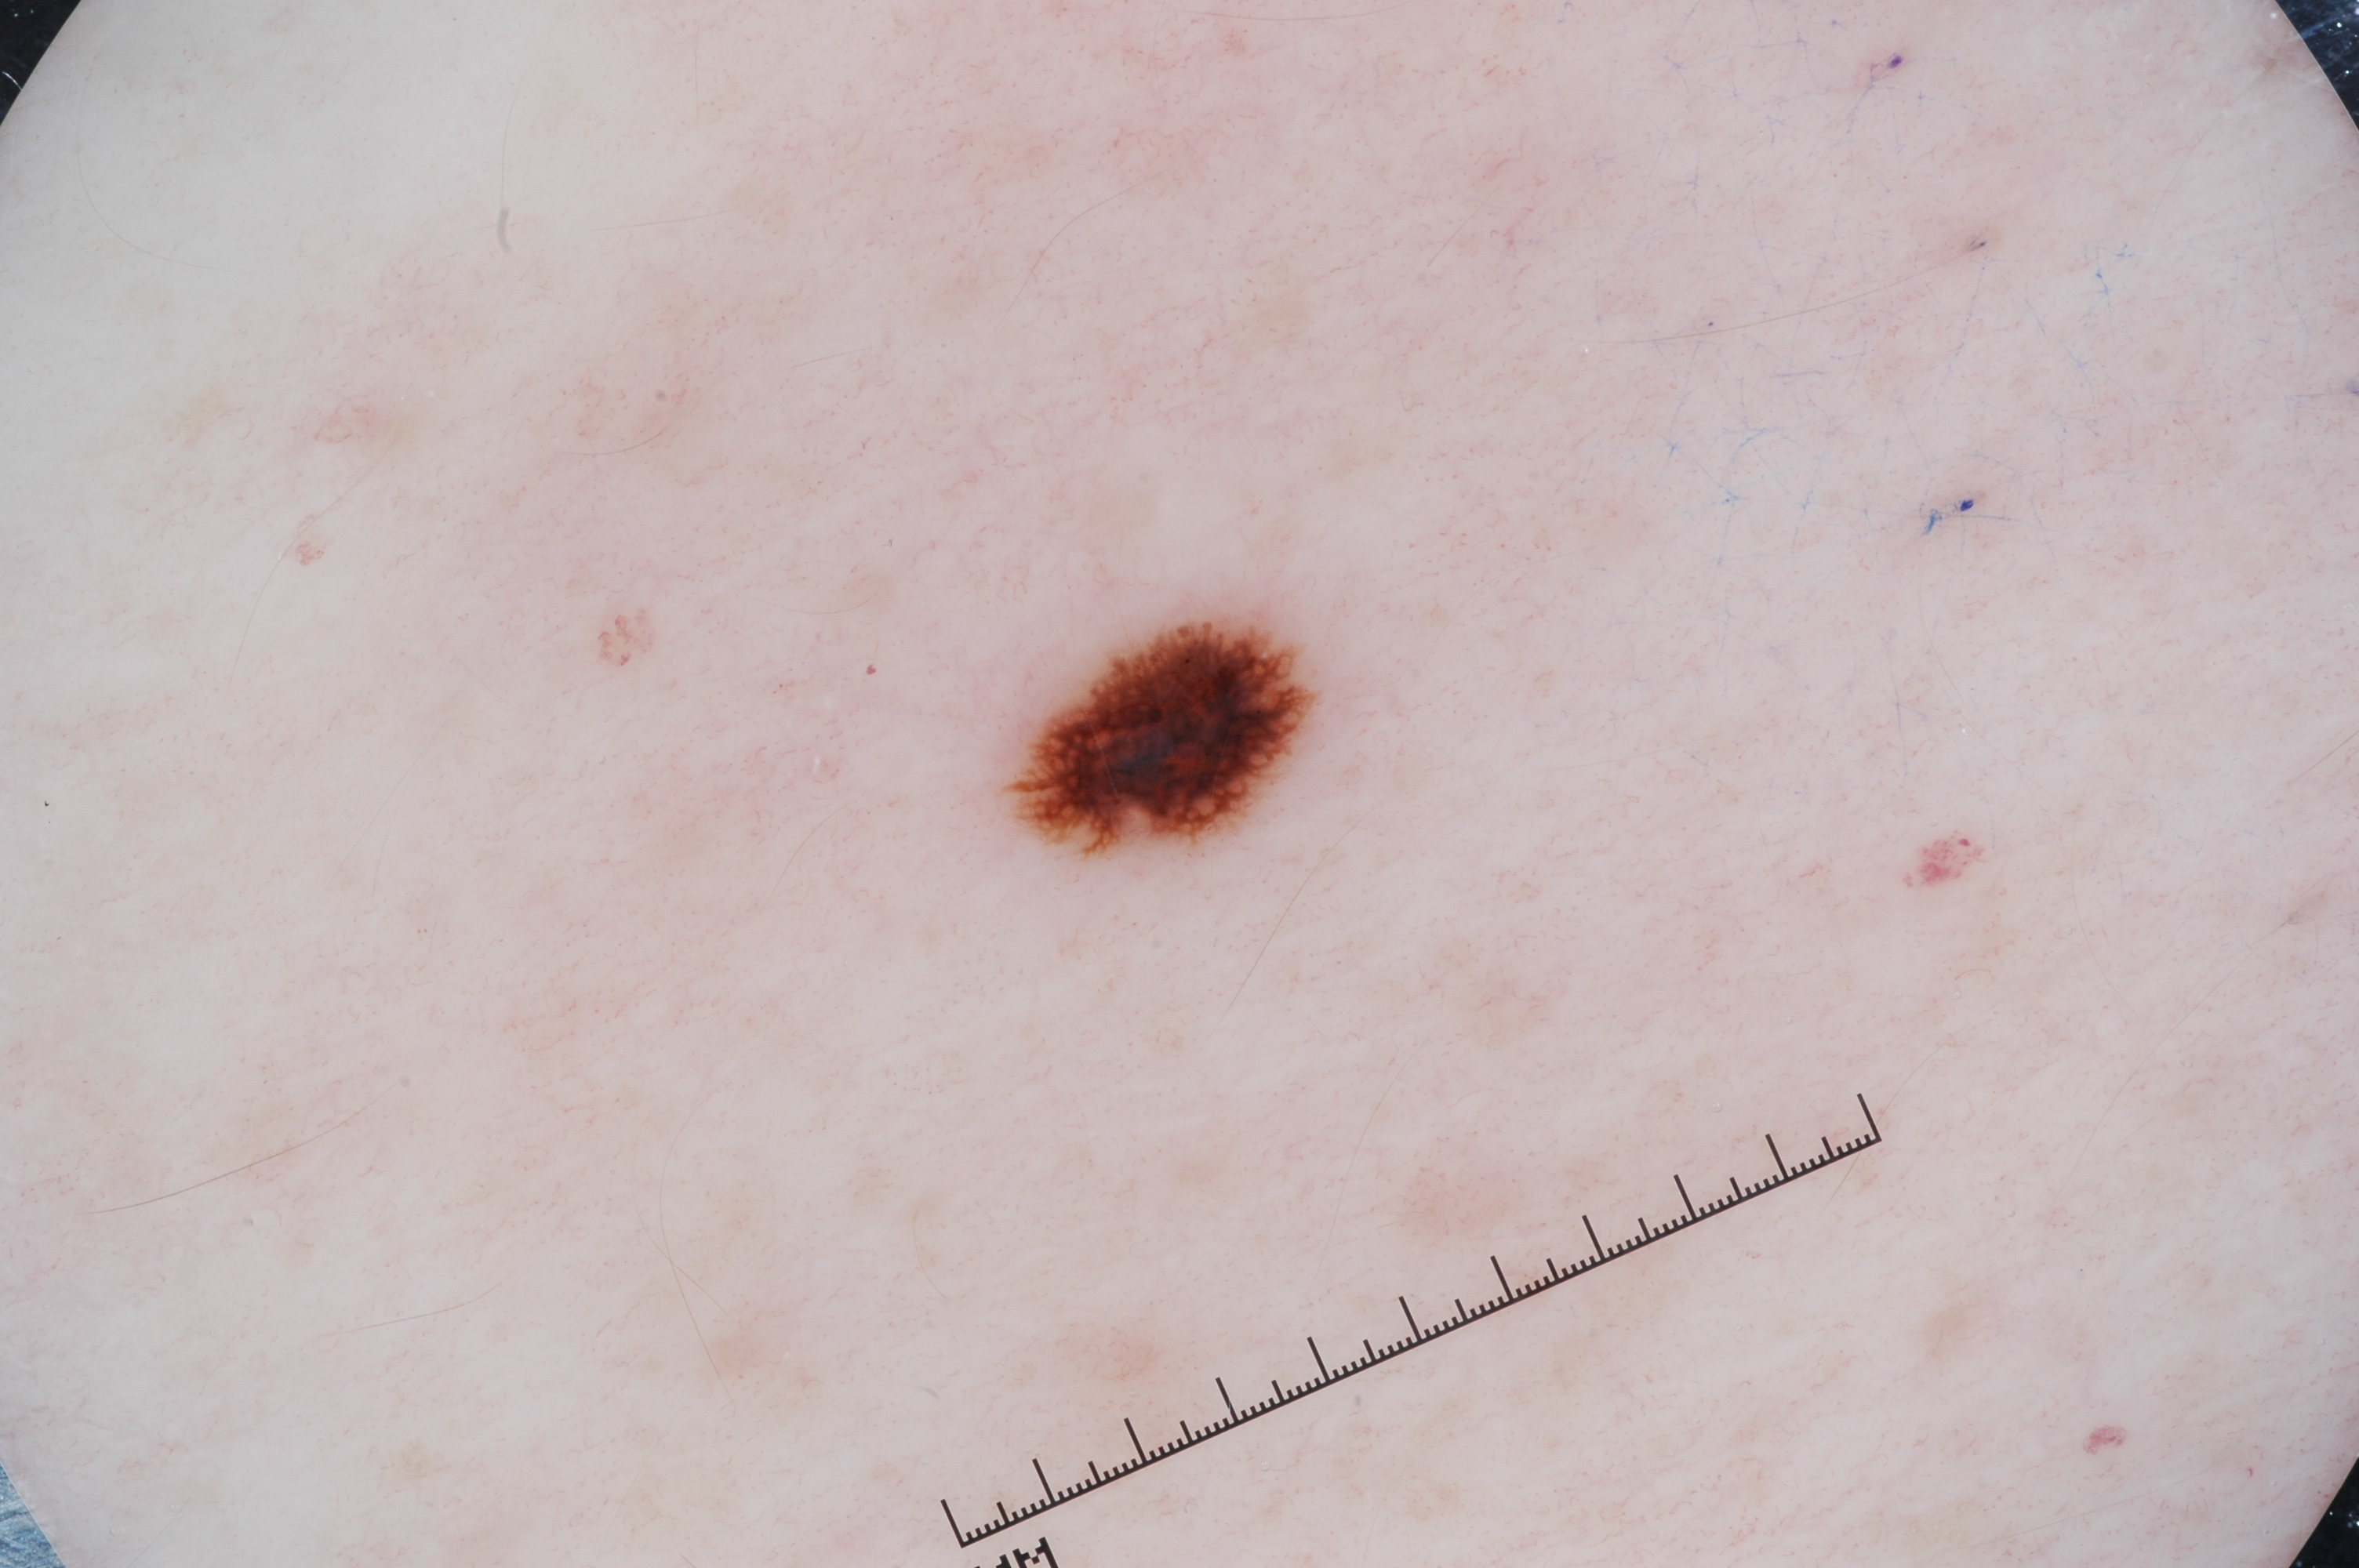

In [ ]:
content_image = Image.open("light_mel.jpg")
content_image

In [ ]:
def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]
    _, n_H, n_W, n_C = a_G.shape
    
    a_C_unrolled = tf.reshape(a_C, shape=(-1, n_H * n_W, n_C))
    a_G_unrolled = tf.reshape(a_G, shape=(-1, n_H * n_W, n_C))
    
    J_content = (1/(4*n_H *n_W*n_C)) * tf.reduce_sum(tf.square(a_G_unrolled - a_C_unrolled))
    
    return J_content

In [ ]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [ ]:
# UNQ_C3
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):

    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=(n_H * n_W, -1)))
    a_G = tf.transpose(tf.reshape(a_G, shape=(n_H * n_W, -1)))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1/(4*n_C*n_C*n_H*n_W*n_H*n_W)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    
    J_style = 0
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [ ]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    
    return J

(1, 400, 400, 3)


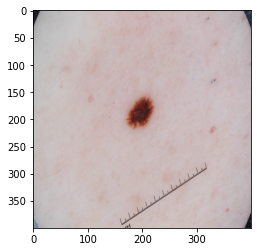

In [ ]:
content_image = np.array(Image.open("light_mel.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


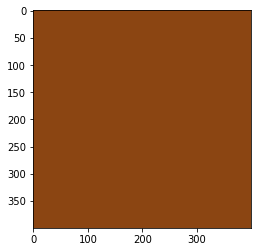

In [ ]:
style_image =  np.array(Image.open("dark.jpg").resize((img_size, img_size)))[:, :, :3]
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


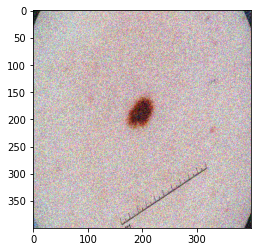

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Load Pre-trained VGG19 Model
Next, as explained in [part(2)](#part(2)), define a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [ ]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

In [ ]:

preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [ ]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [ ]:

generated_image = tf.Variable(generated_image)


Now, run the following code cell to see the results!

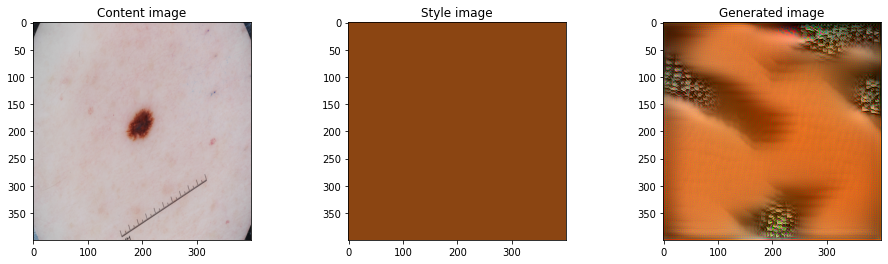

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()